# RNNs

### Getting the data

For this problem we will use a subset of the previous dataset. More specifically, we will only considered those plots that refer to comedy films. Using this criteria, we ensure that the vocabulary will have a manageable extension, and that all the elements of the corpus have similiar contextual information.

In [1]:
import gdown

url = 'https://drive.google.com/uc?id=190D2TxbCObOV9kJNfWaPDOjT4nhenfgc'
output = "movie_plots_rnn.txt"
gdown.download(url, output, quiet=False)

Downloading...
From: https://drive.google.com/uc?id=190D2TxbCObOV9kJNfWaPDOjT4nhenfgc
To: /content/movie_plots_rnn.txt
8.98MB [00:00, 54.5MB/s]


'movie_plots_rnn.txt'

### Preprocessing and cleaning the data

As in the previous case, the initial step is to clean and tokenize the data, in order to remove any non-meaningful information, such as stopwords or capital letters. While in Word2Vec we used the built-in preprocessing function provided by *gensim*, as we will be using Keras on this stage, we will use its own tokenizing function. This function, aside from performing the forementioned operations, converts the input documents into evenly-sized sets of N tokens, which are represented as a list of integers. Each integer is associated with a token.

In [2]:
%tensorflow_version 1.x
import tensorflow as tf
import keras as K
import gensim

def process_input_file(input_file):
  token_list=[]
  with open(input_file,'r',encoding='utf-8',errors='ignore') as f:
    for line in f:
      token_list.append(gensim.utils.simple_preprocess(line))
  return token_list


#First, we create the tokenizing object
tokenizer=K.preprocessing.text.Tokenizer(num_words=None,filters='#$%&()*+-<=>@[\\]^_`{|}~\t\n',lower=True,split=' ')
#Then, we train the tokenizer
documents=process_input_file('./movie_plots_rnn.txt')
tokenizer.fit_on_texts(documents)
sequences=tokenizer.texts_to_sequences(documents)
word_indexes=tokenizer.index_word

TensorFlow 1.x selected.


Using TensorFlow backend.


As in the previous example, we check the values returned by the tokenization function for the first document:

In [3]:
sequences[1]

[75,
 2327,
 31,
 2,
 1172,
 197,
 19,
 777,
 12924,
 2497,
 2150,
 176,
 1159,
 1694,
 281,
 30017,
 14121,
 8,
 149,
 19,
 1,
 12924,
 2,
 840,
 1,
 197,
 21,
 23,
 155,
 56,
 6562,
 11,
 1,
 197,
 418,
 2,
 13,
 6,
 5745,
 9,
 1,
 1173,
 571,
 1,
 8804,
 6791,
 3,
 1,
 1172,
 1577,
 43,
 34,
 1,
 4121,
 419,
 30,
 1,
 197,
 5,
 71,
 176,
 1159,
 5,
 7673,
 53,
 16,
 37,
 4,
 7,
 101,
 26,
 17,
 253,
 19,
 1159,
 60,
 17,
 920,
 7,
 79,
 20,
 111,
 1031,
 9,
 1,
 99,
 3,
 1436,
 2,
 3594,
 3595,
 13,
 620,
 8,
 5,
 1366,
 12,
 10,
 166,
 5130,
 19977]

If we want to transform these sequences of integers back to text:

In [4]:
' '.join([word_indexes[i] for i in sequences[1]])

'before heading out to baseball game at nearby ballpark sports fan mr brown drinks several highball cocktails he arrives at the ballpark to watch the game but has become so inebriated that the game appears to him in reverse with the players running the bases backwards and the baseball flying back into the pitcher hand after the game is over mr brown is escorted home by one of his friends when they arrive at brown house they encounter his wife who becomes furious with the friend and proceeds to physically assault him believing he is responsible for her husband severe intoxication'

### Generating the features and labels for training

As presented in previous sessions, the training goal of a RNN could be formulated as: *Given N words, what is the word N+1 that fits best?*. Thus, we need to transform our tokenized corpus into even sequences of N elements, which will be the features, while the N+1 word of each sequence will be the label. 

For this purpose, we will define a function *make_training_data* that solves this task. This function receives the tokenized integer sequences as a parameter, alongside with the desired amount of features *N*, returning the training set of features and labels. As we have a limited amount of RAM, we must add an extra parameter to limit the number of features to extract.

In [5]:
import numpy as np

def make_training_data(sequences, N,limit=500):
  features=[]
  label_positions=[]
  for s in sequences[:limit]:
    for i in range(N, len(s)):
        chunk = s[i - N:i + 1]
        features.append(chunk[:-1])
        label_positions.append(chunk[-1])
        
  features = np.array(features)
  #one-hot encoding the labels
  total_words=len(word_indexes.keys())
  labels=np.zeros((features.shape[0],total_words))
  for i,l in enumerate(label_positions):
    labels[i,l]=1

  
  return features,labels

In order to generate probability distributions over the possible output words, we need to one-hot encode the labels

In [6]:
max_len=30
features,labels=make_training_data(sequences,30)

Out of the generated set, we generate two different subsets: a training and a validation one:

In [7]:
from sklearn.model_selection import train_test_split
train_features, val_features, train_labels, val_labels = train_test_split(features, labels, test_size=0.25, random_state=2018)
del features
del labels

### Building the RNN

According to their functionality, three different modules can be distinguished within a RNN:
*    **Embedding module**: This module is composed by an embedding layer and, optionally, a masking layer. If we are using pretrained embeddings, we need to setup a masking layer in order to refrain the network from changing the values of the embeddings.
*    **LSTM module**
*    **Fully-connected module** This kind of layers can appear intertwined with LSTMs or at the bottom of the network, as they serve as output layers (in combination with a softmax function)

Additionally, we could introduce some *Dropout* layers, in order to prevent overfitting

To build the RNN, we will use the Keras library on top of Tensorflow.

In [8]:
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, Masking, Embedding,Lambda, Input

model = Sequential()
num_words=len(word_indexes.keys())

model.add(
    Embedding(input_dim=num_words,
              output_dim=100,
              trainable=True,
              mask_zero=False))

model.add(LSTM(64, return_sequences=False, 
               dropout=0.1, recurrent_dropout=0.1))

model.add(Dropout(0,5))

model.add(Dense(64, activation='relu'))

model.add(Dense(num_words, activation='softmax'))

model.compile(
    optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


We have the following network:

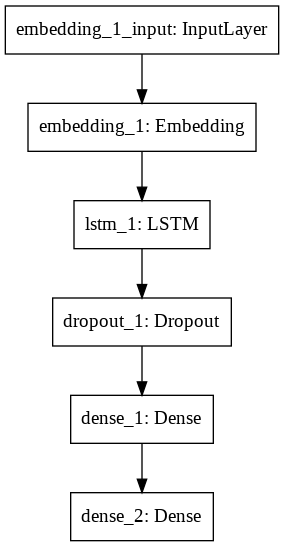

In [9]:
from keras.utils import plot_model
plot_model(model)

The previous model is set **NOT** to use pretrained embeddings. However, there are several sources available where we could retrieve high-quality embeddings from. Two of the most relevant benefits of using pretrained embeddings are:
*   Reduction of training time (as the embedding layer does not need to be trained)
*   Better results (as the pretrained embeddings come from corpuses of over 10x the dimension of our data. Thus, those representations have a much higher quality and expresivity than the ones we could obtain with a small corpus).

Later in this example we will use the pretrained vectors availablle in TensorflowHub for the ElmO model.

### Training and testing the RNN (with embedding training)

Once our RNN is built, we can train it. 

In [10]:
history = model.fit(train_features,  train_labels, 
                    batch_size=256, epochs=10,
                    validation_data=(val_features, val_labels))

model.evaluate(val_features,val_labels)


Train on 22723 samples, validate on 7575 samples
Epoch 1/10
22723/22723 [==============================] - 16s 711us/step - loss: 8.4535 - accuracy: 0.0673 - val_loss: 7.2138 - val_accuracy: 0.0685
Epoch 2/10
22723/22723 [==============================] - 11s 501us/step - loss: 6.7695 - accuracy: 0.0705 - val_loss: 7.1512 - val_accuracy: 0.0685
Epoch 3/10
22723/22723 [==============================] - 11s 499us/step - loss: 6.6078 - accuracy: 0.0705 - val_loss: 7.1822 - val_accuracy: 0.0685
Epoch 4/10
22723/22723 [==============================] - 11s 497us/step - loss: 6.5286 - accuracy: 0.0705 - val_loss: 7.2512 - val_accuracy: 0.0685
Epoch 5/10
22723/22723 [==============================] - 11s 499us/step - loss: 6.4829 - accuracy: 0.0705 - val_loss: 7.3246 - val_accuracy: 0.0685
Epoch 6/10
22723/22723 [==============================] - 11s 501us/step - loss: 6.4455 - accuracy: 0.0727 - val_loss: 7.3682 - val_accuracy: 0.0764
Epoch 7/10
22723/22723 [==============================] 

[7.444925728599624, 0.08462046086788177]

Once the model has been trained, we can then evaluate it. The  model will return the probability per each word in the vocabulary. In order to associate the predicted values to the words in the vocabulary, we first retrieve the index of the word with the highest possibility. Then, we find what word is associated with that key:

In [11]:
X=['There is a keyboard']
input_text=tokenizer.texts_to_sequences(X)
prediction=np.argmax(model.predict(input_text))
word_prediction=word_indexes[prediction]
print(word_prediction)

the


As a single prediction is not representative of the global behaviour of the model, we can also plot its learning and accuracy curves in order to have an overview on the model performance:

No handles with labels found to put in legend.


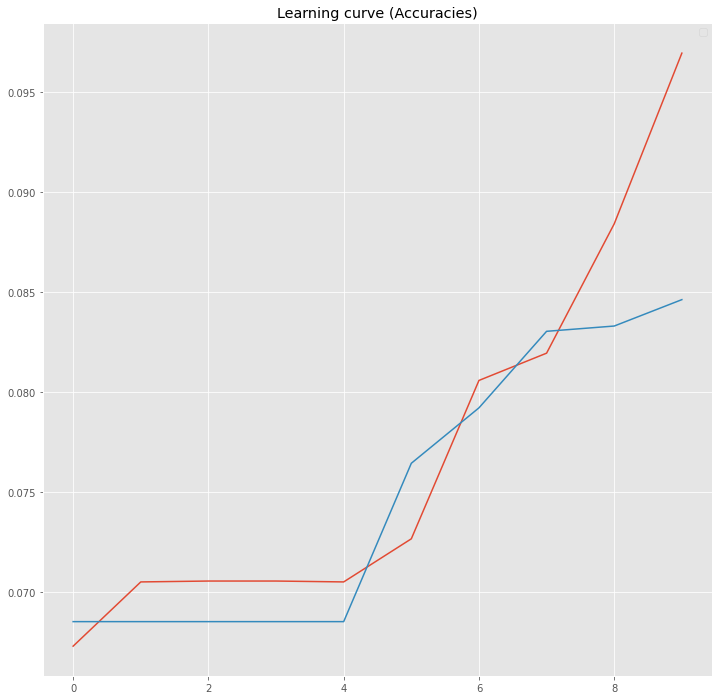

In [12]:
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use("ggplot")
hist = pd.DataFrame(history.history)
plt.figure(figsize=(12,12))
plt.plot(hist["accuracy"])
plt.plot(hist["val_accuracy"])
plt.title("Learning curve (Accuracies)")
plt.legend()
plt.show()

No handles with labels found to put in legend.


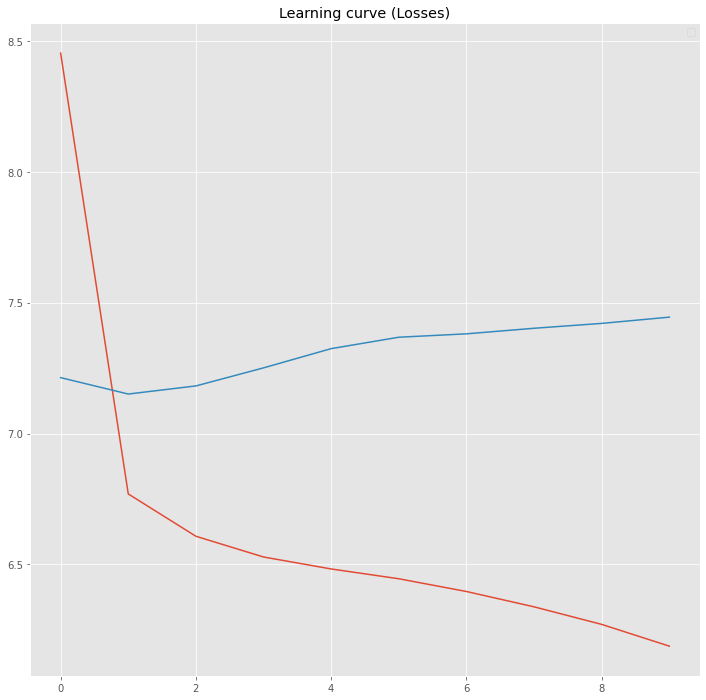

In [13]:
hist = pd.DataFrame(history.history)
plt.figure(figsize=(12,12))
plt.plot(hist["loss"])
plt.plot(hist["val_loss"])
plt.title("Learning curve (Losses)")
plt.legend()
plt.show()

### Training and testing the RNN (with ElmO pretrained embeddings)

While in the previous example we trained the embeddings from scratch, which lead to inaccurate results (about 10% accuracy), in this example we will use pretrained embeddings extracted from an ElmO pretrained model. In order to introduce this new feature, we need to redesign the embedding module of our model:

In [14]:
import tensorflow_hub as hub
from keras import backend as K

sess = tf.Session()
K.set_session(sess)

elmo_model = hub.Module("https://tfhub.dev/google/elmo/2", trainable=True)
sess.run(tf.global_variables_initializer())
sess.run(tf.tables_initializer())

def ElmoEmbeddings(x):
  return elmo_model(inputs={
                            "tokens": tf.squeeze(tf.cast(x, tf.string)),
                            "sequence_len": tf.constant(batch_size*[max_len])
                      },
                      signature="tokens",
                      as_dict=True)["elmo"]

Moreover, we need to change the current format of the input (which is currently a list of integers of variable dimension, each representing a word), in order to be suitable for our new embedding layer. ElmO receives entire sentences in textual form, so that the best representation for each word can be selected depending on the context (polysemy). Thus, we need to define a transformation function, in order to adapt our inputs to the format of the model

In [15]:
def transform_input_to_elmo(input_features,N):
  word_indexes=tokenizer.index_word
  new_input=[]
  for feature in input_features:
    word_feature=[]
    for i in range(N):
      try:
        word_feature.append(word_indexes[feature[i]])
      except:
        word_feature.append("_O_")
    new_input.append(word_feature)
  return new_input

Then, we perform this transformation over our traning and validation sets. 

In [16]:
elmo_train_features=np.array(transform_input_to_elmo(train_features,max_len))
elmo_val_features=np.array(transform_input_to_elmo(val_features,max_len))
del train_features
del val_features

As the Elmo Embedding layer is dependant on the batch_size we select, we need to define it beforehand and adjust the amount of training and validation elements in order to be multiples of this value.

In [17]:
batch_size=32
total=int(elmo_train_features.shape[0]-(elmo_train_features.shape[0]%batch_size))
elmo_train_features=elmo_train_features[:total]
train_labels=train_labels[:total]
total=int(elmo_val_features.shape[0]-(elmo_val_features.shape[0]%batch_size))
elmo_val_features=elmo_val_features[:total]
val_labels=val_labels[:total]

Once we have our datasets ready, we can compile the model with the ElmO embedding layer

In [18]:
from keras.models import Model, Input
from keras.layers.merge import add
from keras.layers import LSTM, Embedding, Dense, TimeDistributed, Dropout, Bidirectional, Lambda

num_words=len(word_indexes.keys())

input_text=Input(shape=(max_len,), dtype=tf.string)

embedding= Lambda(ElmoEmbeddings, output_shape=(max_len,1024))(input_text)

lstm=LSTM(64, return_sequences=False, 
               dropout=0.1, recurrent_dropout=0.1)(embedding)

dropout=Dropout(rate=0.5)(lstm)

dense_1=Dense(64, activation='relu')(dropout)

out = Dense(num_words, activation="softmax")(dense_1)

model=Model(input_text,out)

model.compile(
    optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


Once we have compiled the model, we can train and evaluate it as usual:

In [19]:
history = model.fit(elmo_train_features,  train_labels, validation_data=(elmo_val_features,val_labels),
                    batch_size=32, epochs=10)


Train on 22720 samples, validate on 7552 samples
Epoch 1/10
22720/22720 [==============================] - 141s 6ms/step - loss: 7.4227 - accuracy: 0.0714 - val_loss: 7.0742 - val_accuracy: 0.0906
Epoch 2/10
22720/22720 [==============================] - 123s 5ms/step - loss: 6.5065 - accuracy: 0.1043 - val_loss: 6.8717 - val_accuracy: 0.1226
Epoch 3/10
22720/22720 [==============================] - 131s 6ms/step - loss: 6.2072 - accuracy: 0.1207 - val_loss: 6.8056 - val_accuracy: 0.1339
Epoch 4/10
22720/22720 [==============================] - 127s 6ms/step - loss: 6.0222 - accuracy: 0.1286 - val_loss: 6.8134 - val_accuracy: 0.1357
Epoch 5/10
22720/22720 [==============================] - 131s 6ms/step - loss: 5.8761 - accuracy: 0.1330 - val_loss: 6.8181 - val_accuracy: 0.1422
Epoch 6/10
22720/22720 [==============================] - 131s 6ms/step - loss: 5.7513 - accuracy: 0.1381 - val_loss: 6.8319 - val_accuracy: 0.1453
Epoch 7/10
22720/22720 [==============================] - 131s 

As we previously did, we plot the learning and accuracy curves of the model

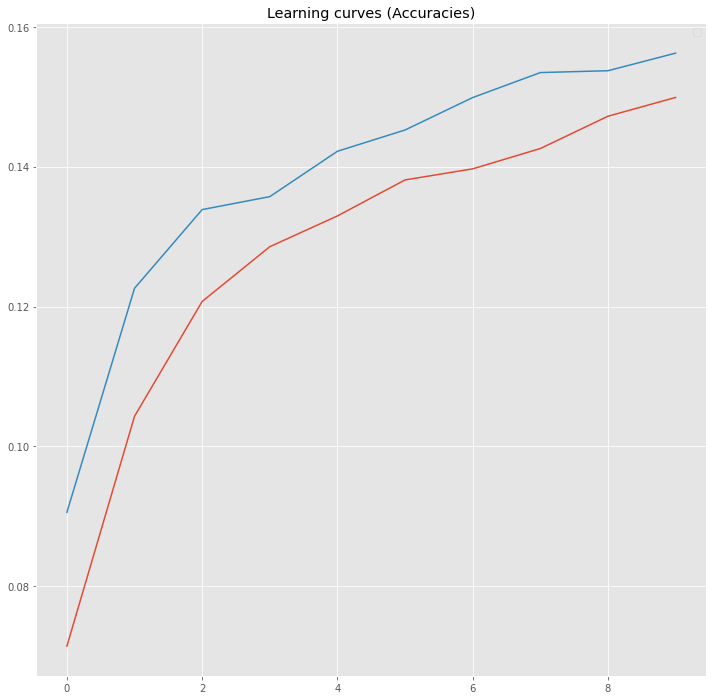

In [20]:
import pandas as pd
hist = pd.DataFrame(history.history)
plt.figure(figsize=(12,12))
plt.plot(hist["accuracy"])
plt.plot(hist["val_accuracy"])
plt.title("Learning curves (Accuracies)")
plt.legend()
plt.show()

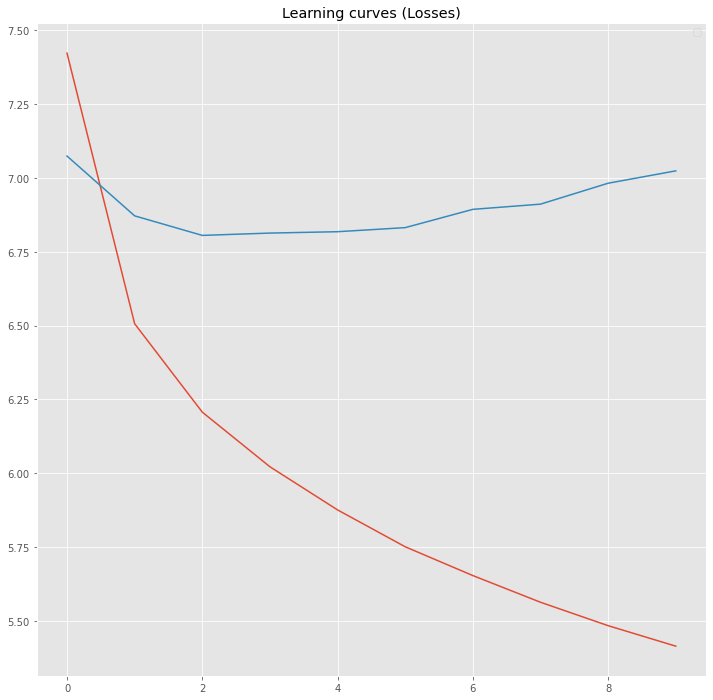

In [21]:
hist = pd.DataFrame(history.history)
plt.figure(figsize=(12,12))
plt.plot(hist["loss"])
plt.plot(hist["val_loss"])
plt.title("Learning curves (Losses)")
plt.legend()
plt.show()

As mentioned previously, this model only accepts **FIX SIZED** inputs. Thus, if we want to predict over a single sentence, we need to generate 31 'mock' sentences composed by padding in order to meet these dimensionality constraints:

In [22]:
X=['There is a keyboard']
input_text=tokenizer.texts_to_sequences(X)
elmo_input=transform_input_to_elmo(input_text,max_len)
padded_input=31*[max_len*['_O_']]
padded_input=np.array(elmo_input+padded_input)
prediction=np.argmax(model.predict(padded_input)[0])
word_prediction=word_indexes[prediction]
print(word_prediction)

and
